In [11]:
#Packages
import warnings
warnings.filterwarnings('ignore')
import glob
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from PIL import Image
from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    FlattenTransformer
)

In [12]:
#PYTEST_VALIDATE_IGNORE_OUTPUT
# %matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
tmp = [
    generate_multiphase(
        shape=(5, 100, 100),
        grain_size=grain_size,
        volume_fraction=volume_fraction,
        chunks=50,
        percent_variance=0.002
    )
    for (grain_size, volume_fraction) in zip(
        [(20, 7), (5, 30), (20, 20)],
        [(0.3, 0.7), (0.3, 0.7), (0.3, 0.7)]
    )
]

x_data = np.concatenate(tmp).persist()
x_data.shape

(15, 100, 100)

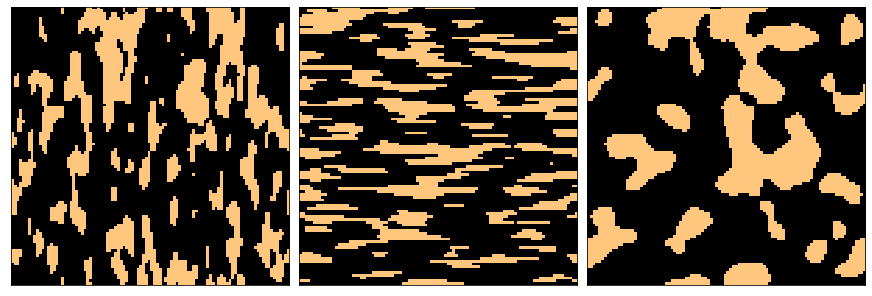

In [31]:
plot_microstructures(*x_data[::6], cmap='copper_r', colorbar=False);

In [32]:
data = PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(x_data)
data.shape

(15, 100, 100, 2)

In [33]:
two_points = TwoPointCorrelation(
    periodic_boundary=True,
    cutoff=15,
    correlations=[(0, 0), (0, 1)]
).transform(data)
two_points.shape

(15, 31, 31, 2)

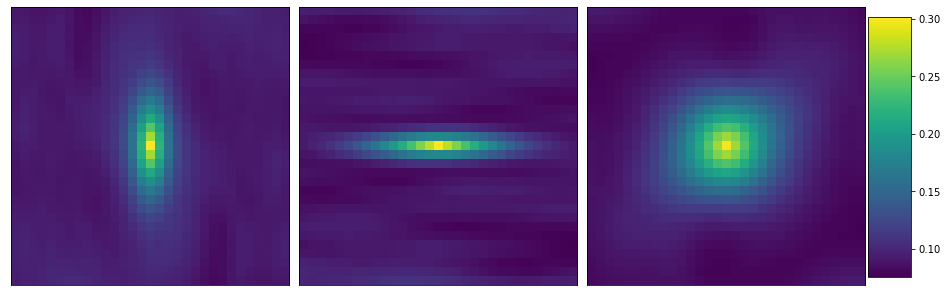

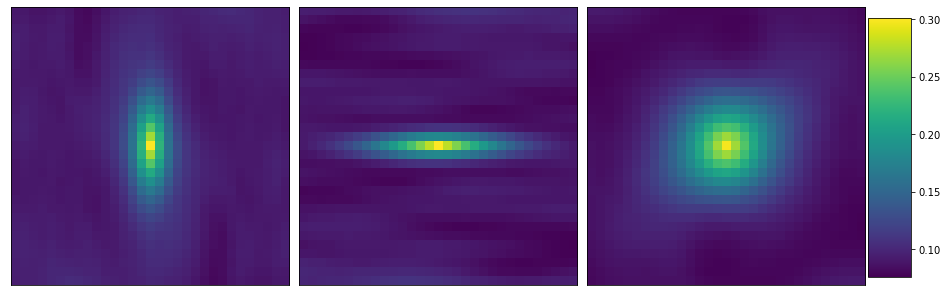

In [34]:
plot_microstructures(
    two_points[0, :, :, 0],
    two_points[6, :, :, 0],
    two_points[12, :, :, 0],
    showticks=False
)

In [35]:
reshaped_two_points=two_points.reshape(15, -1)
reshaped_two_points.shape

(15, 1922)

In [36]:
#Vertical pc scores.
pca = PCA(svd_solver='full', n_components=2, random_state=10)
pc_scores=pca.fit_transform(reshaped_two_points)
pc_scores.shape
print(pc_scores)

[[-0.10127324  0.45182394]
 [ 0.04021902  0.55354978]
 [ 0.06865461  0.50927152]
 [ 0.09143733  0.56286645]
 [-0.09736493  0.49020149]
 [ 0.61702213 -0.25113892]
 [ 0.71377309 -0.21102828]
 [ 0.81418277 -0.19634617]
 [ 0.55238293 -0.30462523]
 [ 0.61977381 -0.34330293]
 [-0.74052595 -0.24412711]
 [-0.80059333 -0.21208631]
 [-0.58281531 -0.29637555]
 [-0.55001053 -0.21150517]
 [-0.64486239 -0.29717751]]


In [37]:
#Explained variance by each principal component.
exp_var_pca=pca.explained_variance_ratio_
print(exp_var_pca)

[0.59287606 0.26331594]


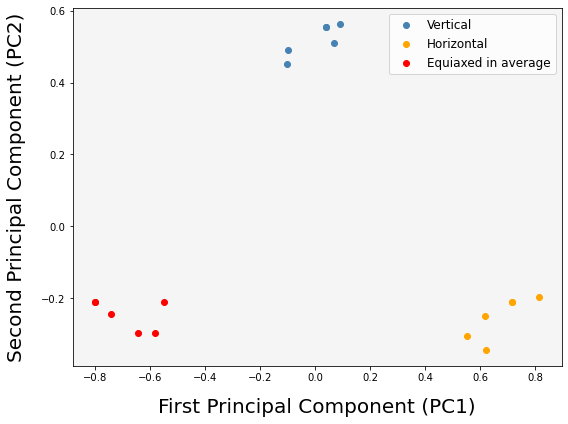

In [38]:
#Principal component analysis visualization.
small = 10
medium = 12
bigger = 18

plt.rc('font', size=small)          # controls default text sizes
plt.rc('axes', titlesize=medium)     # fontsize of the axes title
plt.rc('axes', labelsize=medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small)    # fontsize of the tick labels
plt.rc('legend', fontsize=medium)    # legend fontsize
plt.rc('figure', titlesize=bigger)  # fontsize of the figure title

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for i in range(0,5):
    plt.plot(pc_scores[i,0], pc_scores[i,1], c='steelblue', marker='o')
for j in range(5,10):
    plt.plot(pc_scores[j,0], pc_scores[j,1], c='orange', marker='o')
for k in range(10,15):
    plt.plot(pc_scores[k,0], pc_scores[k,1], c='r', marker='o')

plt.xlabel("First Principal Component (PC1)", fontsize=20, labelpad=15)
plt.ylabel("Second Principal Component (PC2)", fontsize=20, labelpad=15)
#plt.title("PCA Visualization", fontsize=20)

#plt.grid(color = 'black', linestyle = '--', linewidth = 0.4)
ax.set_facecolor('whitesmoke')

#plt.patch.set_edgecolor('black')  
#plt.patch.set_linewidth('1')  

plt.scatter(pc_scores[1,0], pc_scores[1,1], label="Vertical", c='steelblue', marker='o')
plt.scatter(pc_scores[6,0], pc_scores[6,1], label="Horizontal", c='orange', marker='o')
plt.scatter(pc_scores[11,0], pc_scores[11,1], label="Equiaxed in average", c='r', marker='o')

plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(r"C:\Users\mikep\Desktop\thesis\figures\two-point-figure.pdf")
plt.show()